# Lab 03: Estimate proportions using SGD

Task: Debug some code to use stochastic gradient descent to estimate two proportions.

# Scenario

Suppose I have two boxes (A and B), each of which have a bunch of small beads in them. Peeking inside, it looks like there are 3 different colors of beads (red, orange, and yellow), but the two boxes have very different colors.

Each box has a lever on it. When I push the lever, a bead comes out of the box. (We can assume it's a random one, and we'll put the bead back in the box it came from so we don't lose beads.)

My friend suggests we play a game: they'll pick a box and press the lever a few times; I have to guess what color beads are going to come out. But I complain that I'm never going to be able to guess 100% correctly, since the boxes have mixtures of beads in them. So here's what they propose: I can spread out my one guess among the different colors, e.g., 0.5 for red and 0.25 for orange or yellow--as long as they add up to 1. Okay...sounds good?

Even though there's no way I could count the number of each color bead in each box (way too many!), I think I can do well at this game after a few rounds. What do you think?

## Setup

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(10);



```
# This is formatted as code
```

### 1. Define the true (hidden) proportions

Define the true proportions of the 3 colors in each box.

In [2]:
boxes = tensor([
    [600, 550, 350],
    [100, 1300, 100]
]).float()

### 2. Define how we're going to get observations.

Here's how the friend is going to pick which box. We'll get to see which box they pick.

In [3]:
def pick_box():
    return int(torch.rand(1) < .5)
pick_box()

1

In [4]:
def draw_beads(box, num_beads):
    return torch.multinomial(boxes[box], num_beads, replacement=True)
example_beads = draw_beads(box=0, num_beads=5); example_beads

tensor([2, 2, 0, 1, 1])

# Task

The code below plays this game, but it encounters some major problems: it crashes, and even once you fix the crashes, it still doesn't learn the correct proportions.

Debug the code below so that running `get_guesses` gives a good estimate of the true proportions of each color in the given box.

**Mathy Notes**:

* Guessing the true proportions for each box minimizes the cross-entropy loss between observations and guesses (in expectation). So your loss function should be cross-entropy (the negative log of the probability given to the observed sample).
* To ensure that the guesses are valid probability distributions, I recommend you store the *logits* instead of *probabilities*. The `softmax` function turns logits into probabilities. (The `log_softmax` function turns logits into log-probabilities aka logprobs.)

# Solution

First, let's compute the true proportions: divide the counts (in `boxes`) by the total number of beads in each box. Use `sum`, and pass `keepdim=True`

In [5]:
# your code here
# boxes.sum(___)
# boxes / _____
sum= boxes.sum(axis=1, keepdim=True)
boxes/sum


tensor([[0.4000, 0.3667, 0.2333],
        [0.0667, 0.8667, 0.0667]])

### 3. Define how we're going to make a guess

In [6]:
params = tensor([
    [.25, .4, .35],
    [1/3, 1/3, 1/3]])
def get_guess(box):
    guesses_for_box = params[box]
    return guesses_for_box.softmax(dim=0) # <-- you will need to change this line to ensure that the result is a valid probability distribution

example_guess = get_guess(0); example_guess

tensor([0.3061, 0.3556, 0.3383])

### 4. Define how loss is computed.

We can get the probabilities of the actual beads using an indexing trick. For example:

In [7]:
example_guess[example_beads]

tensor([0.3383, 0.3383, 0.3061, 0.3556, 0.3556])

In [8]:
def compute_loss(guess, beads): # <-- note that this is a "loss" (higher = better)... you may want to change it to be a "loss" (lower = better).
    probs_for_observed_beads = guess[beads]
    return -probs_for_observed_beads.log().mean()  # <-- you will need to change this line so that we're using cross-entropy loss
compute_loss(example_guess, example_beads)

tensor(1.0839)

### 5. Use stochastic gradient descent to learn the proportions.

tensor([[0.3705, 0.3506, 0.2789],
        [0.1748, 0.6502, 0.1750]], grad_fn=<StackBackward>)

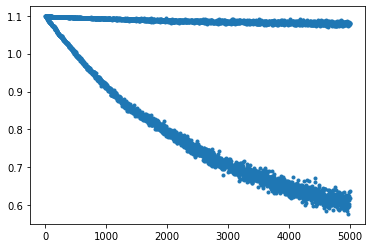

In [15]:
learning_rate=1e-3
batch_size = 1000
params = torch.ones((2, 3)) / 3.0
params.requires_grad_()

losses = []
for i in range(5000):
    box = pick_box()                       # friend picks a box
    my_guess = get_guess(box)              # I make a guess
    
    # Check that my guess is valid.
    assert (my_guess>= 0).all()
    assert (my_guess.sum() - 1.0).abs() < .01

    beads = draw_beads(box, batch_size)            # friend draws a bunch of beads
    loss = compute_loss(my_guess, beads) # friend computes my loss
    losses.append(loss.item())

    # I figure out how I should have guessed differently
    loss.backward()
    params.data -= params.grad * learning_rate
    params.grad.zero_()

# Plot the losss
plt.plot(losses, ".")

# Show the proportions. These should be very close to the true proportions.
torch.stack([get_guess(box=0), get_guess(box=1)])